# Sub-cell Selection for Listing Exercise

**Goal:** Within each matched 5km cell, identify which sub-cells to send listing teams to.

**Approach:**
- Dense 5km cells → sample 500m sub-cells
- Sparse 5km cells → use 1km sub-cells (larger area to find enough farmers)

This notebook helps pick the density threshold.

In [1]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent))

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from src.utils.config_loader import load_config, get_data_dir
from src.data_processing.load_boundaries import load_control_grid, load_subgrid

config = load_config()
data_dir = get_data_dir(config)
print(f"Data directory: {data_dir}")

Loaded local config overrides from config.local.yaml
Data directory: G:\Shared drives\TZ-CCT_RUBEV-0825\Data\1_Baseline\0.4_listing_geospatial


In [2]:
# Load 5km control grid
grid_5km = load_control_grid(data_dir)
print(f"\n5km cells: {len(grid_5km)}")
print(grid_5km["sample_status"].value_counts())

Loaded 48 control grid cells from G:\Shared drives\TZ-CCT_RUBEV-0825\Data\1_Baseline\0.4_listing_geospatial\01_input_data\boundaries\control_grid_5km_flagged.gpkg

5km cells: 48
sample_status
sampled        33
replacement    15
Name: count, dtype: int64


In [3]:
# Load sub-grids with building counts
counts_dir = data_dir / "02_outputs" / "building_counts"

grid_500m = gpd.read_file(counts_dir / "grid_500m_building_counts.gpkg")
grid_1km = gpd.read_file(counts_dir / "grid_1000m_building_counts.gpkg")

print(f"500m sub-cells: {len(grid_500m):,}")
print(f"1km sub-cells:  {len(grid_1km):,}")

500m sub-cells: 4,379
1km sub-cells:  1,115


## Inhabited sub-cells per 5km cell

In [4]:
# Count inhabited sub-cells per 5km cell
# 5km_id links sub-cells to parent
id_5km_col = "5km_id" if "5km_id" in grid_500m.columns else None

if id_5km_col is None:
    # Try spatial join if 5km_id is missing
    print("5km_id not found in sub-grids, checking columns...")
    print(f"500m columns: {list(grid_500m.columns)}")
    print(f"1km columns:  {list(grid_1km.columns)}")
else:
    # 500m stats per 5km cell
    stats_500m = grid_500m.groupby(id_5km_col).agg(
        total_subcells=("building_count", "size"),
        inhabited_subcells=("building_count", lambda x: (x > 0).sum()),
        total_buildings=("building_count", "sum"),
        max_buildings=("building_count", "max"),
        mean_buildings=("building_count", "mean"),
    ).reset_index()
    stats_500m["pct_inhabited"] = 100 * stats_500m["inhabited_subcells"] / stats_500m["total_subcells"]
    
    # 1km stats per 5km cell
    stats_1km = grid_1km.groupby(id_5km_col).agg(
        total_subcells_1km=("building_count", "size"),
        inhabited_subcells_1km=("building_count", lambda x: (x > 0).sum()),
        total_buildings_1km=("building_count", "sum"),
    ).reset_index()
    stats_1km["pct_inhabited_1km"] = 100 * stats_1km["inhabited_subcells_1km"] / stats_1km["total_subcells_1km"]
    
    # Merge
    summary = stats_500m.merge(stats_1km, on=id_5km_col, how="outer")
    
    # Add sample_status from 5km grid
    summary = summary.merge(
        grid_5km[["id", "sample_status"]].rename(columns={"id": id_5km_col}),
        on=id_5km_col,
        how="left",
    )
    
    print(f"\nSummary for {len(summary)} 5km cells:")
    summary.head(10)


Summary for 48 5km cells:


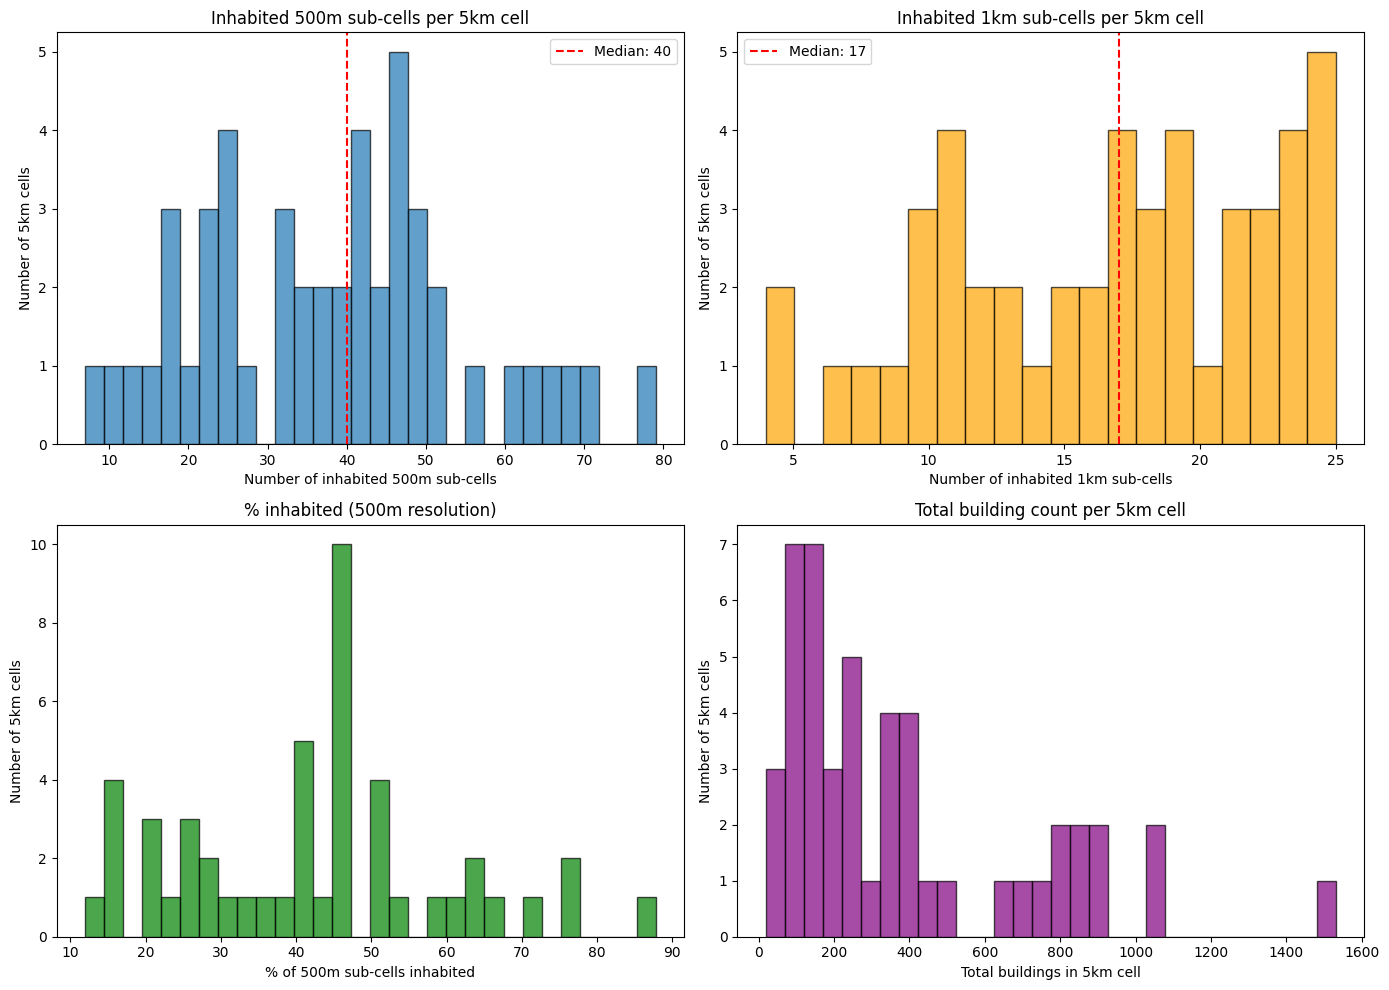

In [5]:
# Distribution of inhabited 500m sub-cells per 5km cell
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histogram: inhabited 500m sub-cells per 5km cell
axes[0, 0].hist(summary["inhabited_subcells"], bins=30, edgecolor="black", alpha=0.7)
axes[0, 0].set_xlabel("Number of inhabited 500m sub-cells")
axes[0, 0].set_ylabel("Number of 5km cells")
axes[0, 0].set_title("Inhabited 500m sub-cells per 5km cell")
axes[0, 0].axvline(summary["inhabited_subcells"].median(), color="red", linestyle="--", label=f'Median: {summary["inhabited_subcells"].median():.0f}')
axes[0, 0].legend()

# Histogram: inhabited 1km sub-cells per 5km cell
axes[0, 1].hist(summary["inhabited_subcells_1km"], bins=20, edgecolor="black", alpha=0.7, color="orange")
axes[0, 1].set_xlabel("Number of inhabited 1km sub-cells")
axes[0, 1].set_ylabel("Number of 5km cells")
axes[0, 1].set_title("Inhabited 1km sub-cells per 5km cell")
axes[0, 1].axvline(summary["inhabited_subcells_1km"].median(), color="red", linestyle="--", label=f'Median: {summary["inhabited_subcells_1km"].median():.0f}')
axes[0, 1].legend()

# % inhabited at 500m
axes[1, 0].hist(summary["pct_inhabited"], bins=30, edgecolor="black", alpha=0.7, color="green")
axes[1, 0].set_xlabel("% of 500m sub-cells inhabited")
axes[1, 0].set_ylabel("Number of 5km cells")
axes[1, 0].set_title("% inhabited (500m resolution)")

# Total buildings per 5km cell
axes[1, 1].hist(summary["total_buildings"], bins=30, edgecolor="black", alpha=0.7, color="purple")
axes[1, 1].set_xlabel("Total buildings in 5km cell")
axes[1, 1].set_ylabel("Number of 5km cells")
axes[1, 1].set_title("Total building count per 5km cell")

plt.tight_layout()
plt.show()

In [6]:
# Key statistics to help pick a threshold
print("=" * 60)
print("INHABITED 500m SUB-CELLS PER 5km CELL")
print("=" * 60)
print(summary["inhabited_subcells"].describe().to_string())
print(f"\nPercentiles:")
for p in [10, 25, 50, 75, 90]:
    val = summary["inhabited_subcells"].quantile(p / 100)
    print(f"  {p}th percentile: {val:.0f} sub-cells")

print(f"\n{'=' * 60}")
print("INHABITED 1km SUB-CELLS PER 5km CELL")
print("=" * 60)
print(summary["inhabited_subcells_1km"].describe().to_string())

print(f"\n{'=' * 60}")
print("TOTAL BUILDINGS PER 5km CELL")
print("=" * 60)
print(summary["total_buildings"].describe().to_string())

INHABITED 500m SUB-CELLS PER 5km CELL
count    48.000000
mean     38.229167
std      16.755107
min       7.000000
25%      24.750000
50%      40.000000
75%      47.500000
max      79.000000

Percentiles:
  10th percentile: 17 sub-cells
  25th percentile: 25 sub-cells
  50th percentile: 40 sub-cells
  75th percentile: 48 sub-cells
  90th percentile: 62 sub-cells

INHABITED 1km SUB-CELLS PER 5km CELL
count    48.000000
mean     16.541667
std       5.667970
min       4.000000
25%      11.750000
50%      17.000000
75%      21.250000
max      25.000000

TOTAL BUILDINGS PER 5km CELL
count      48.000000
mean      384.270833
std       339.186808
min        19.000000
25%       136.000000
50%       229.000000
75%       527.250000
max      1531.000000


## Propose a density threshold

**Adjust the threshold below** based on the distributions above.

In [7]:
# ===== ADJUST THESE THRESHOLDS =====
INHABITED_500M_THRESHOLD = 20  # 5km cells with >= this many inhabited 500m sub-cells are "dense"
N_SAMPLE_500M = 2              # Number of 500m sub-cells to sample in dense cells
MIN_BUILDINGS = 5              # Minimum buildings in a sub-cell to count as "inhabited"
# ====================================

# Recount inhabited sub-cells using MIN_BUILDINGS threshold
inhabited_500m_per_5km = grid_500m[grid_500m["building_count"] >= MIN_BUILDINGS].groupby(id_5km_col).size()
inhabited_1km_per_5km = grid_1km[grid_1km["building_count"] >= MIN_BUILDINGS].groupby(id_5km_col).size()

summary["inhabited_subcells"] = summary[id_5km_col].map(inhabited_500m_per_5km).fillna(0).astype(int)
summary["inhabited_subcells_1km"] = summary[id_5km_col].map(inhabited_1km_per_5km).fillna(0).astype(int)

summary["density_class"] = np.where(
    summary["inhabited_subcells"] >= INHABITED_500M_THRESHOLD,
    "dense",
    "sparse",
)

dense = summary[summary["density_class"] == "dense"]
sparse = summary[summary["density_class"] == "sparse"]

print(f"Min buildings per sub-cell: {MIN_BUILDINGS}")
print(f"Dense threshold: {INHABITED_500M_THRESHOLD} inhabited 500m sub-cells")
print(f"\n  Dense 5km cells:  {len(dense)} → sample {N_SAMPLE_500M} x 500m sub-cells each")
print(f"  Sparse 5km cells: {len(sparse)} → use inhabited 1km sub-cells (>= {MIN_BUILDINGS} buildings)")
print(f"\nDense cells:")
print(f"  Total inhabited 500m sub-cells: {dense['inhabited_subcells'].sum():,}")
print(f"  Sub-cells to visit (sampled):   {len(dense) * N_SAMPLE_500M:,}")
print(f"\nSparse cells:")
print(f"  Total inhabited 1km sub-cells:  {sparse['inhabited_subcells_1km'].sum():,.0f}")
print(f"  Sub-cells to visit (all):       {sparse['inhabited_subcells_1km'].sum():,.0f}")
print(f"\nTotal sub-cells to visit: {len(dense) * N_SAMPLE_500M + sparse['inhabited_subcells_1km'].sum():,.0f}")

Min buildings per sub-cell: 5
Dense threshold: 20 inhabited 500m sub-cells

  Dense 5km cells:  17 → sample 2 x 500m sub-cells each
  Sparse 5km cells: 31 → use inhabited 1km sub-cells (>= 5 buildings)

Dense cells:
  Total inhabited 500m sub-cells: 460
  Sub-cells to visit (sampled):   34

Sparse cells:
  Total inhabited 1km sub-cells:  213
  Sub-cells to visit (all):       213

Total sub-cells to visit: 247


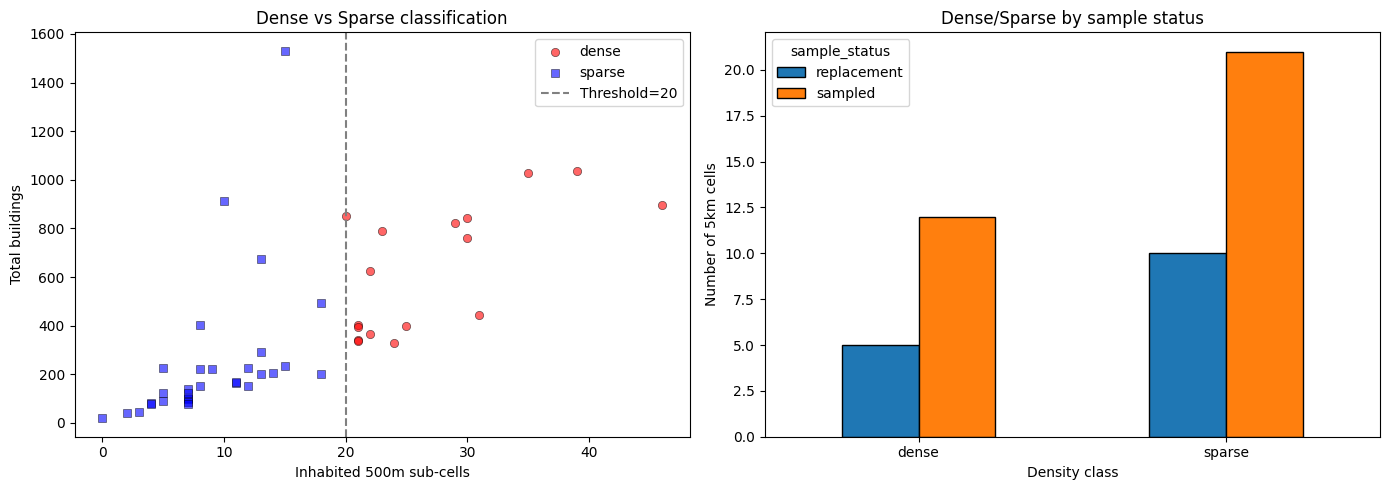

In [11]:
# Visualise the classification
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter: inhabited sub-cells vs total buildings, colored by class
for cls, color, marker in [("dense", "red", "o"), ("sparse", "blue", "s")]:
    subset = summary[summary["density_class"] == cls]
    axes[0].scatter(
        subset["inhabited_subcells"],
        subset["total_buildings"],
        c=color, marker=marker, alpha=0.6, label=cls, edgecolors="black", linewidth=0.5,
    )
axes[0].axvline(INHABITED_500M_THRESHOLD, color="gray", linestyle="--", label=f"Threshold={INHABITED_500M_THRESHOLD}")
axes[0].set_xlabel("Inhabited 500m sub-cells")
axes[0].set_ylabel("Total buildings")
axes[0].set_title("Dense vs Sparse classification")
axes[0].legend()

# Bar: counts by class and sample_status
ct = summary.groupby(["density_class", "sample_status"]).size().unstack(fill_value=0)
ct.plot(kind="bar", ax=axes[1], edgecolor="black")
axes[1].set_title("Dense/Sparse by sample status")
axes[1].set_xlabel("Density class")
axes[1].set_ylabel("Number of 5km cells")
axes[1].tick_params(axis="x", rotation=0)

plt.tight_layout()
plt.show()

## Preview: what the selection looks like

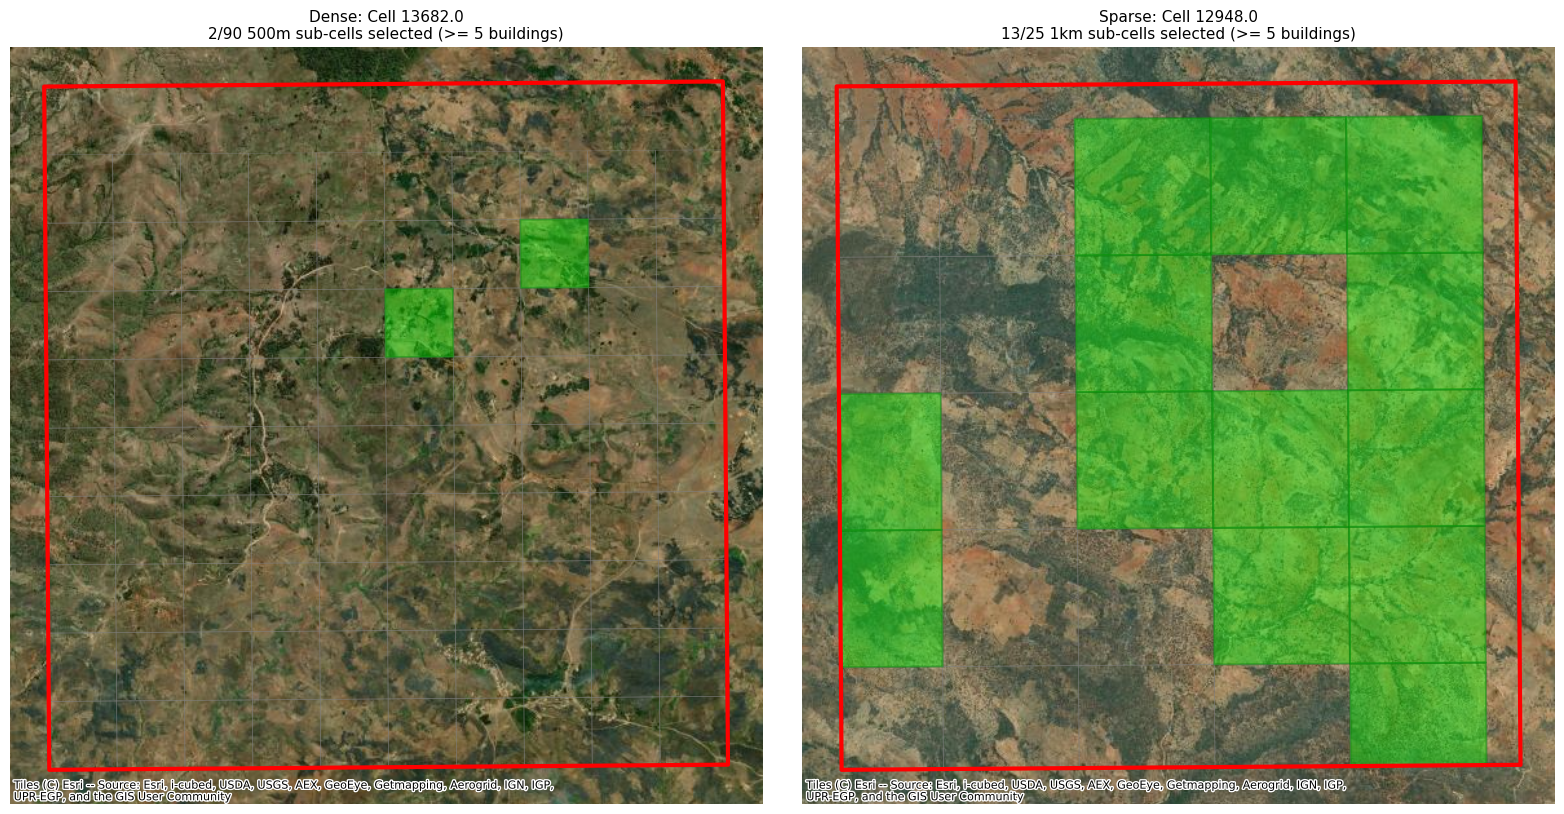

In [12]:
# Show a dense and a sparse 5km cell side by side
import contextily as cx

BASEMAP = cx.providers.Esri.WorldImagery

# Pick one dense and one sparse cell
dense_cell_id = dense.sort_values("inhabited_subcells", ascending=False).iloc[0][id_5km_col]
sparse_cell_id = sparse.sort_values("inhabited_subcells_1km", ascending=False).iloc[0][id_5km_col]

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

for ax, cell_id, label in [(axes[0], dense_cell_id, "Dense"), (axes[1], sparse_cell_id, "Sparse")]:
    # Get parent 5km cell
    parent = grid_5km[grid_5km["id"] == cell_id]
    
    # Get sub-cells
    if label == "Dense":
        subcells = grid_500m[grid_500m[id_5km_col] == cell_id].copy()
        inhabited = subcells[subcells["building_count"] >= MIN_BUILDINGS]
        # Random sample of N
        if len(inhabited) > N_SAMPLE_500M:
            selected = inhabited.sample(N_SAMPLE_500M, random_state=42)
        else:
            selected = inhabited
        res_label = "500m"
    else:
        subcells = grid_1km[grid_1km[id_5km_col] == cell_id].copy()
        selected = subcells[subcells["building_count"] >= MIN_BUILDINGS]
        res_label = "1km"
    
    # Plot in Web Mercator
    parent_wm = parent.to_crs(epsg=3857)
    subcells_wm = subcells.to_crs(epsg=3857)
    selected_wm = selected.to_crs(epsg=3857)
    
    # All sub-cells (gray)
    subcells_wm.plot(ax=ax, facecolor="none", edgecolor="gray", linewidth=0.5, alpha=0.5)
    # Selected sub-cells (green)
    selected_wm.plot(ax=ax, facecolor="lime", edgecolor="green", linewidth=1.5, alpha=0.4)
    # Parent boundary (red)
    parent_wm.plot(ax=ax, facecolor="none", edgecolor="red", linewidth=3)
    
    # Basemap
    minx, miny, maxx, maxy = parent_wm.total_bounds
    buf = (maxx - minx) * 0.05
    ax.set_xlim(minx - buf, maxx + buf)
    ax.set_ylim(miny - buf, maxy + buf)
    cx.add_basemap(ax, source=BASEMAP, zoom="auto")
    
    n_selected = len(selected)
    n_total = len(subcells)
    ax.set_title(f"{label}: Cell {cell_id}\n{n_selected}/{n_total} {res_label} sub-cells selected (>= {MIN_BUILDINGS} buildings)", fontsize=11)
    ax.set_axis_off()

plt.tight_layout()
plt.show()

In [10]:
# Full summary table
display_cols = [id_5km_col, "sample_status", "density_class",
                "inhabited_subcells", "total_subcells", "pct_inhabited",
                "inhabited_subcells_1km", "total_buildings"]
summary[display_cols].sort_values("total_buildings", ascending=False)

,5km_id,sample_status,density_class,inhabited_subcells,total_subcells,pct_inhabited,inhabited_subcells_1km,total_buildings
23,13151.0,sampled,sparse,15,100,25.000000,6,1531
36,13866.0,sampled,dense,39,90,87.777778,21,1035
40,14051.0,replacement,dense,35,100,46.000000,15,1029
15,12418.0,sampled,sparse,10,100,40.000000,7,913
31,13682.0,sampled,dense,46,90,75.555556,21,895
4,10761.0,replacement,dense,20,87,63.218391,16,852
7,11114.0,sampled,dense,30,100,51.000000,14,845
30,13681.0,sampled,dense,29,79,58.227848,14,823
27,13497.0,replacement,dense,23,70,45.714286,10,790
38,13868.0,sampled,dense,30,100,63.000000,19,760
